**Lab2-DL: A4-MNIST-Random-Forest.ipynb** (ELMED219) | Prioritet: 3 (valgfri)

_MNIST-klassifisering med Random Forest – etabler en ML-baseline_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A4-MNIST-Random-Forest.ipynb)

Sist oppdatert: 2025-12-04, A. Lundervold

Bruk `elmed219-2026` conda-miljøet eller Google Colab

---

## Hvorfor Random Forest på bilder?

### Læringsreisen: Fra tradisjonell ML til dyp læring

I denne serien av notebooks utforsker vi **tre tilnærminger** til bildeklassifikasjon:

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  A4: Random     │ →  │  A5: MLP        │ →  │  A6: CNN        │
│  Forest         │    │  (Nevrale nett) │    │  (Dyp læring)   │
│ ≈92% nøyaktighet│    │ ≈97% nøyaktighet│    │ ≈99% nøyaktighet│
└─────────────────┘    └─────────────────┘    └─────────────────┘
     BASELINE              FORBEDRING            STATE-OF-ART
```

### Hvorfor starter vi med Random Forest?

| Grunn | Forklaring |
|-------|------------|
| **Baseline** | Vi trenger noe å sammenligne dyp læring med |
| **Tolkbarhet** | Random Forest gir innsikt i hvilke piksler som er viktige |
| **Enkelhet** | Ingen hyperparameter-tuning av nettverksarkitektur |
| **Robusthet** | Fungerer bra uten GPU eller spesiell hardware |

### Medisinsk relevans

Random Forest brukes fortsatt i medisinsk AI for:
- **Radiomics**: Klassifisering basert på teksturfeatures fra CT/MR
- **Tabelldata**: Pasientkarakteristikker, labverdier
- **Hybrid-modeller**: Kombinert med dyp læring-features

> 💡 **Huskeregel**: Start alltid med en enkel baseline før du går til komplekse modeller!

In [18]:
# === Sjekk kjøremiljø ===

try:
    import google.colab
    ER_COLAB = True
    print("✅ Kjører i Google Colab")
except ImportError:
    ER_COLAB = False
    print("💻 Kjører lokalt (ikke Colab)")

💻 Kjører lokalt (ikke Colab)


---

## 1. Importer og forberedelser

In [19]:
# === Importer nødvendige biblioteker ===

import numpy as np                    # Numerisk beregning
import pandas as pd                   # Tabelldata
import matplotlib.pyplot as plt       # Visualisering
import seaborn as sns                 # Statistisk visualisering
import os                             # Filhåndtering
from pathlib import Path              # Stihåndtering

# Scikit-learn: Maskinlæring
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

print("✅ Alle biblioteker lastet inn")

✅ Alle biblioteker lastet inn


---

## 2. Last inn MNIST-data

Vi bruker datasettet som ble forberedt i **A3-MNIST-datasamling.ipynb**. Hvis filen ikke finnes, genererer vi den på nytt.

In [20]:
# === Last inn MNIST-data ===

data_mappe = Path('mnist_data')
data_mappe.mkdir(exist_ok=True)

# Prøv komprimert fil først, deretter ukomprimert
gzip_fil = data_mappe / 'mnist_20000bilder.csv.gz'
csv_fil = data_mappe / 'mnist_20000bilder.csv'

if gzip_fil.exists():
    print(f"📂 Laster data fra komprimert fil: {gzip_fil}")
    mnist_data = pd.read_csv(gzip_fil)
elif csv_fil.exists():
    print(f"📂 Laster data fra CSV-fil: {csv_fil}")
    mnist_data = pd.read_csv(csv_fil)
else:
    print("⏳ Genererer MNIST-data fra PyTorch...")
    from torchvision import datasets
    import torchvision.transforms as transforms
    
    # Last ned MNIST
    mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                                  transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True,
                                 transform=transforms.ToTensor())
    
    # Konverter og kombiner
    X_train = mnist_train.data.numpy().reshape(60000, -1) / 255.0
    X_test = mnist_test.data.numpy().reshape(10000, -1) / 255.0
    y_train = mnist_train.targets.numpy()
    y_test = mnist_test.targets.numpy()
    
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])
    
    # Ta tilfeldig utvalg
    np.random.seed(42)
    indekser = np.random.choice(len(X), 5000, replace=False)
    
    # Lag DataFrame
    kolonner = [f'piksel_{i}' for i in range(784)]
    mnist_data = pd.DataFrame(X[indekser], columns=kolonner)
    mnist_data['etikett'] = y[indekser]
    
    # Lagre komprimert
    mnist_data.to_csv(gzip_fil, index=False, compression='gzip')
    print(f"✅ Data lagret til {gzip_fil}")

print(f"\n📊 Datasett-dimensjoner: {mnist_data.shape}")
print(f"   {mnist_data.shape[0]} bilder × {mnist_data.shape[1]-1} piksler + 1 etikett")

📂 Laster data fra komprimert fil: mnist_data/mnist_20000bilder.csv.gz

📊 Datasett-dimensjoner: (20000, 785)
   20000 bilder × 784 piksler + 1 etikett


### Stratifisert trenings/test-oppdeling

Vi deler dataene slik at klassefordelingen bevares i begge deler.

In [21]:
# === Del opp i trenings- og testdata ===

# Finn etikettkolonnen (kan hete 'label' eller 'etikett')
etikett_kolonne = 'etikett' if 'etikett' in mnist_data.columns else 'label'

# Stratifisert oppdeling: 80% trening, 20% test
treningsdata, testdata = train_test_split(
    mnist_data,
    test_size=0.2,
    random_state=42,
    stratify=mnist_data[etikett_kolonne]
)

# Separer features og etiketter
X_trening = treningsdata.drop(etikett_kolonne, axis=1)
y_trening = treningsdata[etikett_kolonne]
X_test = testdata.drop(etikett_kolonne, axis=1)
y_test = testdata[etikett_kolonne]

print(f"📊 Dataoppdeling:")
print(f"   Trening: {len(X_trening)} bilder")
print(f"   Test:    {len(X_test)} bilder")

📊 Dataoppdeling:
   Trening: 16000 bilder
   Test:    4000 bilder


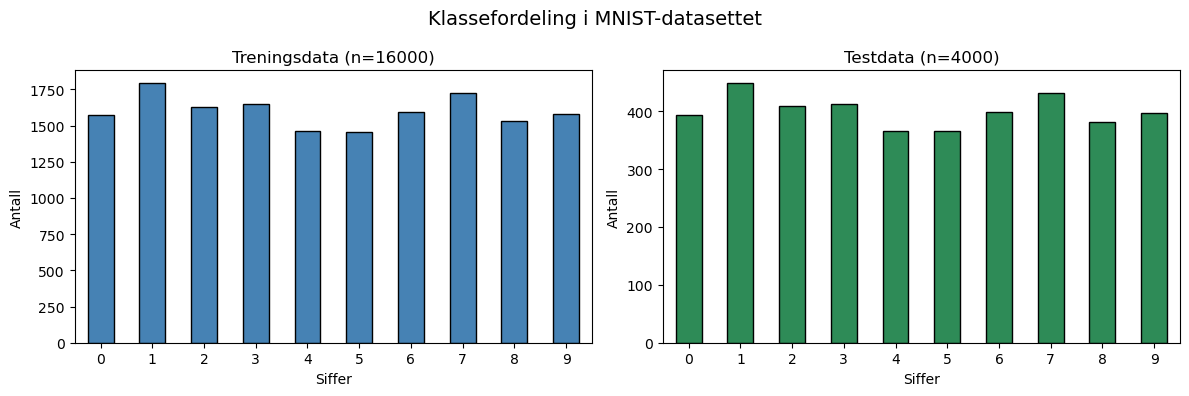

✅ Stratifisert oppdeling bevarer klassebalansen


In [22]:
# === Visualiser klassefordeling ===

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Treningsdata
y_trening.value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='black'
)
axes[0].set_title(f'Treningsdata (n={len(y_trening)})', fontsize=12)
axes[0].set_xlabel('Siffer')
axes[0].set_ylabel('Antall')
axes[0].set_xticklabels(range(10), rotation=0)

# Testdata
y_test.value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color='seagreen', edgecolor='black'
)
axes[1].set_title(f'Testdata (n={len(y_test)})', fontsize=12)
axes[1].set_xlabel('Siffer')
axes[1].set_ylabel('Antall')
axes[1].set_xticklabels(range(10), rotation=0)

plt.suptitle('Klassefordeling i MNIST-datasettet', fontsize=14)
plt.tight_layout()
plt.show()

print("✅ Stratifisert oppdeling bevarer klassebalansen")

---

## 3. Visualiser eksempler

La oss se på noen av bildene vi skal klassifisere.

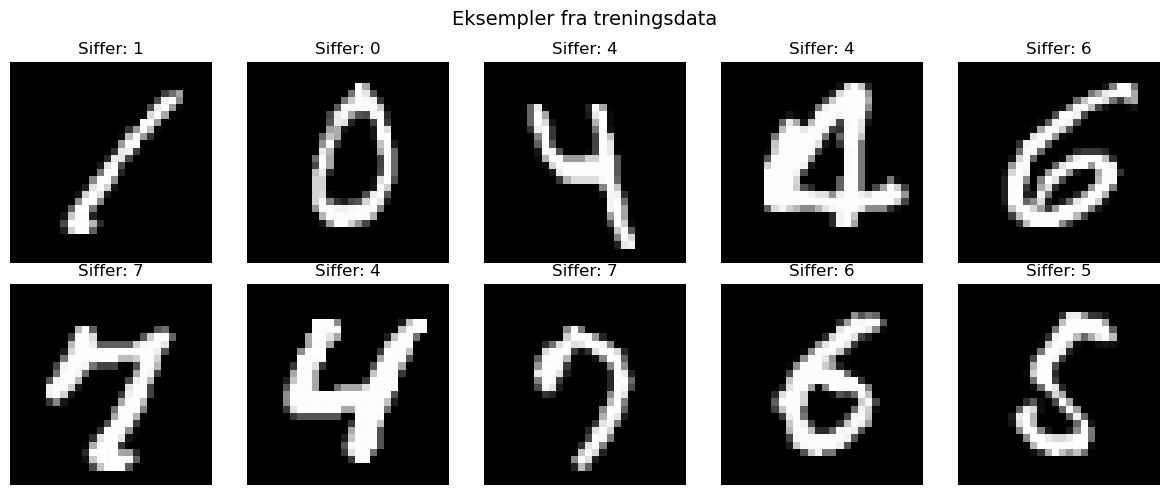

In [23]:
# === Vis eksempelbilder ===

def vis_siffer(data, indeks, etiketter=None, prediksjon=None):
    """Viser et enkelt MNIST-siffer."""
    # Hent pikseldata (alle kolonner unntatt etikett)
    piksel_kolonner = [k for k in data.columns if k != etikett_kolonne]
    bilde = data.iloc[indeks][piksel_kolonner].values.reshape(28, 28)
    
    plt.imshow(bilde, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    
    sann_etikett = int(data.iloc[indeks][etikett_kolonne])
    if prediksjon is not None:
        plt.title(f'Pred: {prediksjon}\nSann: {sann_etikett}')
    else:
        plt.title(f'Siffer: {sann_etikett}')

# Vis 10 tilfeldige eksempler
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

np.random.seed(123)
indekser = np.random.choice(len(treningsdata), 10, replace=False)

for i, idx in enumerate(indekser):
    plt.sca(axes[i])
    vis_siffer(treningsdata.reset_index(drop=True), i)

plt.suptitle('Eksempler fra treningsdata', fontsize=14)
plt.tight_layout()
plt.show()

---

## 4. Tren Random Forest-modellen

### Hvordan fungerer Random Forest på bilder?

Random Forest behandler hvert bilde som en **flat vektor** med 784 features (piksler):

```
28×28 bilde  →  [p₀, p₁, p₂, ..., p₇₈₃]  →  Random Forest  →  Klasse (0-9)
```

**Begrensning**: Modellen ser ikke på romlig struktur – bare individuelle pikselverdier!

In [24]:
# === Tren Random Forest ===

print("🌲 Trener Random Forest-klassifikator...")
print(f"   Antall trenings-eksempler: {len(X_trening)}")
print(f"   Antall features (piksler): {X_trening.shape[1]}")

# Opprett og tren modellen
rf_modell = RandomForestClassifier(
    n_estimators=100,      # 100 beslutningstrær
    random_state=42,       # Reproduserbarhet
    n_jobs=-1              # Bruk alle CPU-kjerner
)

rf_modell.fit(X_trening, y_trening)

print("\n✅ Modell trent!")
print(f"   Antall trær: {rf_modell.n_estimators}")
print(f"   Antall klasser: {rf_modell.n_classes_}")

🌲 Trener Random Forest-klassifikator...
   Antall trenings-eksempler: 16000
   Antall features (piksler): 784

✅ Modell trent!
   Antall trær: 100
   Antall klasser: 10


---

## 5. Evaluer modellen

### Klassifikasjonsrapport

Vi bruker standard evalueringsmetrikker fra medisinsk diagnostikk:
- **Precision** (presisjon): Hvor mange av predikerte positive er faktisk positive?
- **Recall** (sensitivitet): Hvor mange av faktisk positive ble funnet?
- **F1-score**: Harmonisk gjennomsnitt av precision og recall

In [25]:
# === Evaluer modellen ===

print("📊 Evaluerer modellen på testdata...\n")

# Prediker på testdata
y_pred = rf_modell.predict(X_test)

# Klassifikasjonsrapport
print("Klassifikasjonsrapport:")
print("="*60)
print(classification_report(y_test, y_pred, 
                            target_names=[f'Siffer {i}' for i in range(10)]))

📊 Evaluerer modellen på testdata...

Klassifikasjonsrapport:
              precision    recall  f1-score   support

    Siffer 0       0.96      0.97      0.97       393
    Siffer 1       0.98      0.99      0.98       448
    Siffer 2       0.94      0.97      0.95       408
    Siffer 3       0.93      0.91      0.92       412
    Siffer 4       0.96      0.96      0.96       366
    Siffer 5       0.95      0.95      0.95       365
    Siffer 6       0.98      0.98      0.98       399
    Siffer 7       0.95      0.96      0.95       431
    Siffer 8       0.92      0.91      0.92       382
    Siffer 9       0.94      0.91      0.93       396

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



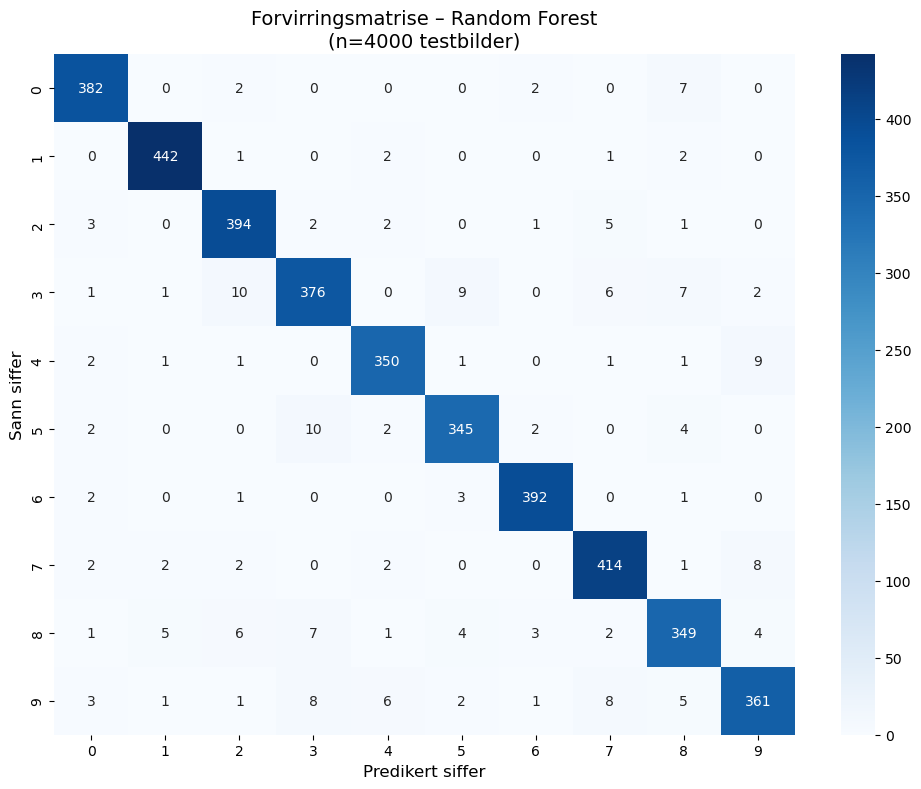


📊 Oppsummering:
   Nøyaktighet (accuracy): 95.1%
   Feilrate:               4.9%


In [26]:
# === Forvirringsmatrise ===

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))

plt.title(f'Forvirringsmatrise – Random Forest\n(n={len(y_test)} testbilder)', 
          fontsize=14)
plt.xlabel('Predikert siffer', fontsize=12)
plt.ylabel('Sann siffer', fontsize=12)
plt.tight_layout()
plt.show()

# Oppsummeringsmetrikker
nøyaktighet = accuracy_score(y_test, y_pred)
print(f"\n📊 Oppsummering:")
print(f"   Nøyaktighet (accuracy): {nøyaktighet:.1%}")
print(f"   Feilrate:               {1-nøyaktighet:.1%}")

### Tolkning av resultatene

**Hva viser forvirringsmatrisen?**
- Diagonalen = korrekte prediksjoner
- Utenfor diagonalen = feil (forvirring mellom siffer)

**Typiske feil:**
- 8 ↔ 5: Lignende kurvet struktur
- 4 ↔ 9: Lignende topp
- 3 ↔ 8: Kurvet form

> 💡 **Baseline etablert**: ~92% nøyaktighet. Kan vi gjøre det bedre med nevrale nettverk?

### ROC-kurver (one-vs-all)

ROC-kurven viser avveiningen mellom sensitivitet og spesifisitet.

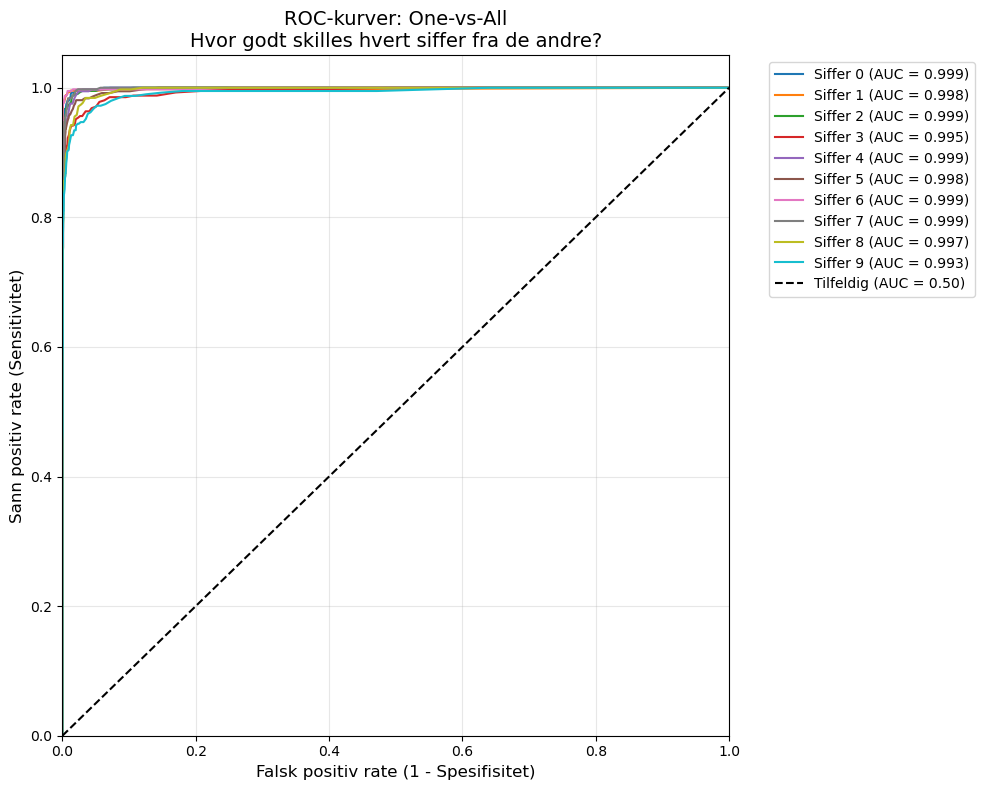


📊 Gjennomsnittlig ROC AUC: 0.9975


In [27]:
# === ROC-kurver for hvert siffer ===

# Hent sannsynlighetsprediksjoner
y_prob = rf_modell.predict_proba(X_test)

# Binariser etikettene for ROC-beregning
y_test_bin = label_binarize(y_test, classes=range(10))

# Beregn ROC for hvert siffer
plt.figure(figsize=(10, 8))

roc_auc = {}
for siffer in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, siffer], y_prob[:, siffer])
    roc_auc[siffer] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Siffer {siffer} (AUC = {roc_auc[siffer]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Tilfeldig (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsk positiv rate (1 - Spesifisitet)', fontsize=12)
plt.ylabel('Sann positiv rate (Sensitivitet)', fontsize=12)
plt.title('ROC-kurver: One-vs-All\nHvor godt skilles hvert siffer fra de andre?', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gjennomsnitt_auc = np.mean(list(roc_auc.values()))
print(f"\n📊 Gjennomsnittlig ROC AUC: {gjennomsnitt_auc:.4f}")

---

## 6. Feature importance – Hvilke piksler er viktigst?

En stor fordel med Random Forest er **tolkbarhet**. Vi kan se hvilke piksler modellen bruker mest for å ta beslutninger.

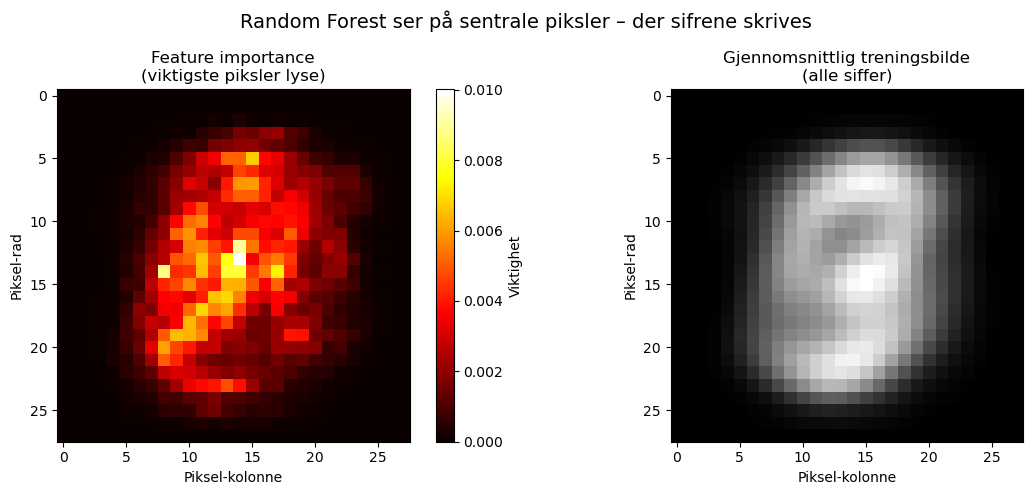

In [28]:
# === Visualiser feature importance ===

# Hent feature importance og reshape til bildedimensjoner
viktighet = rf_modell.feature_importances_
viktighet_bilde = viktighet.reshape(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Feature importance heatmap
im = axes[0].imshow(viktighet_bilde, cmap='hot')
axes[0].set_title('Feature importance\n(viktigste piksler lyse)', fontsize=12)
axes[0].set_xlabel('Piksel-kolonne')
axes[0].set_ylabel('Piksel-rad')
plt.colorbar(im, ax=axes[0], label='Viktighet')

# Sammenlign med gjennomsnittlig siffer
gjennomsnitt_bilde = X_trening.values.mean(axis=0).reshape(28, 28)
axes[1].imshow(gjennomsnitt_bilde, cmap='gray')
axes[1].set_title('Gjennomsnittlig treningsbilde\n(alle siffer)', fontsize=12)
axes[1].set_xlabel('Piksel-kolonne')
axes[1].set_ylabel('Piksel-rad')

plt.suptitle('Random Forest ser på sentrale piksler – der sifrene skrives', fontsize=14)
plt.tight_layout()
plt.show()

---

## 7. Analyser feilklassifiseringer

La oss se på noen eksempler der modellen tar feil.

🔍 Antall feilklassifiseringer: 195 av 4000 (4.9%)



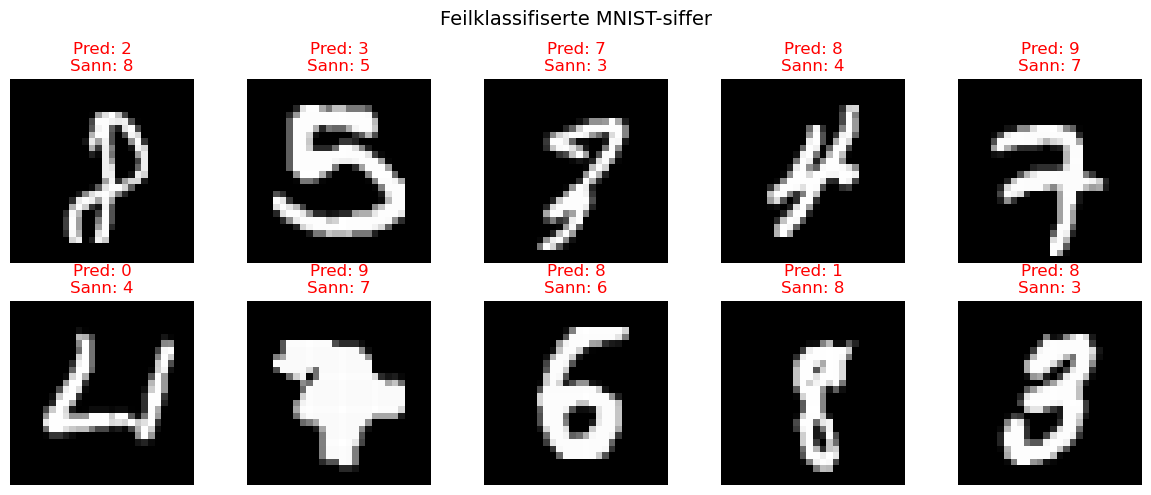

In [29]:
# === Vis feilklassifiserte eksempler ===

# Finn feil
feil_indekser = np.where(y_test.values != y_pred)[0]
print(f"🔍 Antall feilklassifiseringer: {len(feil_indekser)} av {len(y_test)} ({len(feil_indekser)/len(y_test):.1%})\n")

# Vis 10 feilklassifiserte eksempler
n_vis = min(10, len(feil_indekser))
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(n_vis):
    idx = feil_indekser[i]
    bilde = X_test.iloc[idx].values.reshape(28, 28)
    
    axes[i].imshow(bilde, cmap='gray')
    axes[i].axis('off')
    sann = y_test.iloc[idx]
    pred = y_pred[idx]
    axes[i].set_title(f'Pred: {pred}\nSann: {sann}', 
                      color='red' if pred != sann else 'black')

plt.suptitle('Feilklassifiserte MNIST-siffer', fontsize=14)
plt.tight_layout()
plt.show()

---

## 8. Lagre modellen

In [30]:
# === Lagre modellen ===

import joblib

modell_fil = data_mappe / 'mnist_random_forest.joblib'
joblib.dump(rf_modell, modell_fil)

print(f"✅ Modell lagret til: {modell_fil}")
print(f"   Filstørrelse: {modell_fil.stat().st_size / 1e6:.1f} MB")

✅ Modell lagret til: mnist_data/mnist_random_forest.joblib
   Filstørrelse: 50.5 MB


---

## Oppsummering og veien videre

### Hva vi har oppnådd

| Metrikk | Random Forest |
|---------|---------------|
| **Nøyaktighet** | ~92% |
| **ROC AUC** | ~0.99 |
| **Treningstid** | Sekunder |
| **Tolkbarhet** | Høy (feature importance) |

### Begrensninger

Random Forest ser ikke **romlig struktur** i bildene:
- Behandler piksler uavhengig
- Ingen forståelse av naboskap
- Rotasjon/translasjon gir helt andre features

### Neste steg: Sammenligning

```
┌─────────────────────────────────────────────────────────────┐
│  Modell            Nøyaktighet   Romlig struktur   GPU     │
├─────────────────────────────────────────────────────────────┤
│  Random Forest     ~92%          Nei               Nei     │
│  MLP (A5)          ~97%          Nei               Nei     │
│  CNN (A6)          ~99%          JA! ✓             Valgfri │
└─────────────────────────────────────────────────────────────┘
```

> **Gå videre til A5-MNIST-MLP.ipynb** for å se hvordan nevrale nettverk forbedrer resultatene!

---

## 🎯 Oppgaver

### Oppgave 1: Endre antall trær
Prøv å trene med `n_estimators=10` og `n_estimators=500`. Hvordan påvirker dette nøyaktigheten og treningstiden?

<details>
<summary>💡 Vis svar</summary>

```python
import time

for n_trees in [10, 100, 500]:
    start = time.time()
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf.fit(X_trening, y_trening)
    tid = time.time() - start
    acc = accuracy_score(y_test, rf.predict(X_test))
    print(f"n_trees={n_trees}: Nøyaktighet={acc:.3f}, Tid={tid:.1f}s")
```
Flere trær → marginalt bedre nøyaktighet, men lenger treningstid.

</details>

### Oppgave 2: Hvilke siffer er vanskeligst?
Bruk forvirringsmatrisen til å identifisere de tre siffer-parene med flest forvekslinger.

<details>
<summary>💡 Vis svar</summary>

Se på cellene utenfor diagonalen i forvirringsmatrisen. Typisk er de vanskeligste parene:
1. 8 ↔ 5 (lignende kurver)
2. 4 ↔ 9 (lignende topp)
3. 3 ↔ 8 (kurvet form)

</details>